# Balance dataset: selection of trials

Marcos Duarte

In [1]:
import numpy as np
from scipy.signal import butter, filtfilt
import pandas as pd
pd.set_option('precision', 3)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
sns.set_context("notebook", font_scale=1.4,
                rc={'font.size': 14, 'lines.linewidth': 1, 'lines.markersize': 8, 'axes.titlesize': 'x-large'})
sns.set_style("whitegrid")
import glob
import sys, os
sys.path.insert(1, r'./../functions')

# IPython widgets:
from IPython.display import display
import ipywidgets
from ipywidgets import FloatProgress, interactive

import qgrid  # pip install git+https://github.com/quantopian/qgrid
#qgrid.nbinstall(overwrite=True)  # copies javascript dependencies to /nbextensions folder
qgrid.set_defaults(remote_js=True, precision=2)  # Set default options by calling "set_defaults" (optional)

from AMTIbsf import loadbsf
from psd import psd
from hyperellipsoid import hyperellipsoid

## Load other information about the subjects

In [2]:
path = r'./../../../X/BDB/'
fname = 'BDSinfoS.txt'
BDSinfo = pd.read_csv(os.path.join(path, fname), sep='\t', header=0, index_col=0, engine='c', encoding='utf-8')
print("Information of %s subjects loaded (%s rows, %s columns)."
      %(len(pd.unique(BDSinfo.Subject)), BDSinfo.shape[0], BDSinfo.shape[1]))

Information of 231 subjects loaded (2741 rows, 64 columns).


Here are the first 12 columns of the data:

In [3]:
qgrid.show_grid(BDSinfo.iloc[:, :12])

## Data selection

Here are examples of how to select part of the data using the power of Pandas (see http://pandas.pydata.org/pandas-docs/stable/indexing.html):

In [5]:
# Select data from a single subject:
data = BDSinfo[BDSinfo.Subject==1]
print('There are %d trials for subject 1' %data.shape[0])
# Select data from a single condition:
data = BDSinfo[BDSinfo.Vision=='Open']
print('There are %d trials for the "Open" visual condition.' %data.shape[0])
# Select data based on multiple criteria:
criteria = (BDSinfo.AgeGroup=='Young') & (BDSinfo.Gender=='F')
data = BDSinfo[criteria]
print('There are %d trials satisfying the criteria AgeGroup = "Young" and Gender = "F".' %data.shape[0])

There are 10 trials for subject 1
There are 1376 trials for the "Open" visual condition.
There are 756 trials satisfying the criteria AgeGroup = "Young" and Gender = "F".


## Jupyter widget for data selection

With [Jupyter widgets](https://github.com/ipython/ipywidgets) we can create widgects for data selection:

In [6]:
subjects = np.hstack(('All subjects', np.sort(pd.unique(BDSinfo.Subject))))
ages = np.hstack(('All ages', pd.unique(BDSinfo.AgeGroup)))
genders = np.hstack(('All genders', pd.unique(BDSinfo.Gender)))
disability = np.hstack(('All conditions', pd.unique(BDSinfo.Disability)))
illness = np.hstack(('All conditions', pd.unique(BDSinfo.Illness)))
visions = np.hstack(('All visions', pd.unique(BDSinfo.Vision)))
surfaces = np.hstack(('All surfaces', pd.unique(BDSinfo.Surface)))

wsubjects = ipywidgets.Dropdown(options=list(subjects), value='All subjects', description='Subjects', width=300, margin=2)
wages = ipywidgets.Dropdown(options=list(ages), value='All ages', description='Ages', width=300, margin=2)
wgenders = ipywidgets.Dropdown(options=list(genders), value='All genders', description='Genders', width=300, margin=2)
wdisabilitys = ipywidgets.Dropdown(options=list(disability), value='All conditions', description='Disabilities', width=300, margin=2)
willness = ipywidgets.Dropdown(options=list(illness), value='All conditions', description='Illness', width=300, margin=2)
wvisions = ipywidgets.Dropdown(options=list(visions), value='All visions', description='Visions', width=300, margin=2)
wsurfaces = ipywidgets.Dropdown(options=list(surfaces), value='All surfaces', description='Surfaces', width=300, margin=2)
t1 = ipywidgets.HTML(value="<b>Trials selection for the database:</b>")
trial_sel = ipywidgets.VBox(children=[t1, wsubjects, wgenders, wages, wdisabilitys, willness, wvisions, wsurfaces])

wsubjects2 = ipywidgets.Dropdown(options=list(subjects), value='All subjects', description='Subjects', width=300, margin=2)
wages2 = ipywidgets.Dropdown(options=list(ages), value='All ages', description='Ages', width=300, margin=2)
wgenders2 = ipywidgets.Dropdown(options=list(genders), value='All genders', description='Genders', width=300, margin=2)
wdisabilitys2 = ipywidgets.Dropdown(options=list(disability), value='All conditions', description='Disabilities', width=300, margin=2)
willness2 = ipywidgets.Dropdown(options=list(illness), value='All conditions', description='Illness', width=300, margin=2)
wvisions2 = ipywidgets.Dropdown(options=list(visions), value='All visions', description='Visions', width=300, margin=2)
wsurfaces2 = ipywidgets.Dropdown(options=list(surfaces), value='All surfaces', description='Surfaces', width=300, margin=2)
t2 = ipywidgets.HTML(value="<b>Trials selection for the comparison:</b>")
trial_sel2 = ipywidgets.VBox(children=[t2, wsubjects2, wgenders2, wages2, wdisabilitys2, willness2, wvisions2, wsurfaces2])

container = ipywidgets.HBox(children=[trial_sel, trial_sel2])
container.border_color = '#F2F2F2'
container.border_width = 2
container.background_color = '#F2F2F2'
display(container)

#wmean = ipywidgets.Checkbox(description="Remove mean from COP:", value=True, width=50, margin=2)
#wscale = ipywidgets.Checkbox(description="Same plot limits:", value=True, width=50, margin=2)
#parameters = ipywidgets.HBox(children=[wmean, wscale])
#parameters.background_color = '#F2F2F2'
#t2 = ipywidgets.HTML(value="<b>Parameters</b>")
#container = ipywidgets.VBox(children=[t1, trial_sel, t2, parameters])
#container = ipywidgets.VBox(children=[t1, trial_sel])

## Summary results for selected data

In [7]:
subject_sel = list(subjects) if wsubjects.value == 'All subjects' else wsubjects.value
subject_sel = BDSinfo['Subject'].map(lambda x: str(x) in subject_sel)
gender_sel = ['F', 'M'] if wgenders.value == 'All genders' else wgenders.value
gender_sel = BDSinfo['Gender'].map(lambda x: x in gender_sel)
if wages.value == 'All ages':
    age_sel = BDSinfo['Age'].map(lambda x: x > 0)
elif wages.value == 'Young':
    age_sel = BDSinfo['Age'].map(lambda x: x < 60)
else:
    age_sel = BDSinfo['Age'].map(lambda x: x >= 60)
disability_sel = ['Yes', 'No'] if wdisabilitys.value == 'All conditions' else wdisabilitys.value
disability_sel = BDSinfo['Disability'].map(lambda x: x in disability_sel)
illness_sel = ['Yes', 'No'] if willness.value == 'All conditions' else willness.value
illness_sel = BDSinfo['Illness'].map(lambda x: x in illness_sel)
vision_sel = ['Open', 'Closed'] if wvisions.value == 'All visions' else wvisions.value
vision_sel = BDSinfo['Vision'].map(lambda x: x in vision_sel)
surface_sel = ['Firm', 'Foam'] if wsurfaces.value == 'All surfaces' else wsurfaces.value
surface_sel = BDSinfo['Surface'].map(lambda x: x in surface_sel)
sel = BDSinfo[subject_sel & gender_sel & age_sel & illness_sel & disability_sel & vision_sel & surface_sel]
print('%s subjects selected.' %len(pd.unique(sel.Subject)))
sel.groupby(['Vision', 'Surface'])['COParea', 'COPvelo'].agg(np.median)

subject_sel2 = list(subjects) if wsubjects2.value == 'All subjects' else wsubjects2.value
subject_sel2 = BDSinfo['Subject'].map(lambda x: str(x) in subject_sel2)
gender_sel2 = ['F', 'M'] if wgenders2.value == 'All genders' else wgenders2.value
gender_sel2 = BDSinfo['Gender'].map(lambda x: x in gender_sel2)
if wages2.value == 'All ages':
    age_sel2 = BDSinfo['Age'].map(lambda x: x > 0)
elif wages2.value == 'Young':
    age_sel2 = BDSinfo['Age'].map(lambda x: x < 60)
else:
    age_sel2 = BDSinfo['Age'].map(lambda x: x >= 60)
disability_sel2 = ['Yes', 'No'] if wdisabilitys2.value == 'All conditions' else wdisabilitys2.value
disability_sel2 = BDSinfo['Disability'].map(lambda x: x in disability_sel2)
illness_sel2 = ['Yes', 'No'] if willness2.value == 'All conditions' else willness2.value
illness_sel2 = BDSinfo['Illness'].map(lambda x: x in illness_sel2)
vision_sel2 = ['Open', 'Closed'] if wvisions2.value == 'All visions' else wvisions2.value
vision_sel2 = BDSinfo['Vision'].map(lambda x: x in vision_sel2)
surface_sel2 = ['Firm', 'Foam'] if wsurfaces2.value == 'All surfaces' else wsurfaces2.value
surface_sel2 = BDSinfo['Surface'].map(lambda x: x in surface_sel2)
sel2 = BDSinfo[subject_sel2 & gender_sel2 & age_sel2 & illness_sel2 & disability_sel2 & vision_sel2 & surface_sel2]
print('%s subjects selected.' %len(pd.unique(sel2.Subject)))
sel2.groupby(['Vision', 'Surface'])['COParea', 'COPvelo'].agg(np.median)

120 subjects selected.
88 subjects selected.


COParea  COPvelo
Vision Surface                  
Closed Firm       1.935    1.203
       Foam      23.701    4.349
Open   Firm       1.899    1.115
       Foam      18.694    3.642

In [9]:
def bdb_plot_barplot(data=sel, sel=sel2, var='COParea', ylabel='Area ( cm$^2$)',
                     estimator=np.median, ci=95, ax=None, legend=None, sel_lege=True):
    palette = {'Open': [.8, .8, .9], 'Closed': [.4, .4, .9]}
    axi = sns.barplot(x="Surface", y=var, hue="Vision", order=['Firm', 'Foam'], data=data, ci=ci,
                       hue_order=['Open', 'Closed'], estimator=estimator, palette=palette, ax=ax)
    if ylabel:
        ax.set_ylabel(ylabel)
    if legend:
        axi.legend(title='Eyes', loc='best')
    else:
        ax.legend('')
    # get the x,y values of the confidence intervals:
    xyci = []
    for ch in axi.get_children():
        if isinstance(ch, matplotlib.lines.Line2D):
            xyci.append(ch.get_data())
    if sel is not None:
        median = sel.groupby(['Vision', 'Surface'])['COParea', 'COPvelo'].agg(estimator)
        axi.plot(xyci[0][0][0], median[var]['Open']['Firm'], marker='o', color='r', markersize=10, label='Subject')
        axi.plot(xyci[2][0][0], median[var]['Closed']['Firm'], marker='o', color='r', markersize=10)
        axi.plot(xyci[1][0][0], median[var]['Open']['Foam'], marker='o', color='r', markersize=10)
        axi.plot(xyci[3][0][0], median[var]['Closed']['Foam'], marker='o', color='r', markersize=10)  
        x = axi.get_xlim()[0] + .05*(axi.get_xlim()[1]-axi.get_xlim()[0])
        y = axi.get_ylim()[0] + .9*(axi.get_ylim()[1]-axi.get_ylim()[0])
        x2 = axi.get_xlim()[0] + .1*(axi.get_xlim()[1]-axi.get_xlim()[0])
        y2 = axi.get_ylim()[0] + .88*(axi.get_ylim()[1]-axi.get_ylim()[0])
        if sel_lege:
            axi.plot(x, y, marker='o', color='r', markersize=10)
            axi.text(x2, y2, 'Subject', fontsize=14)
        
    return ax, xyci

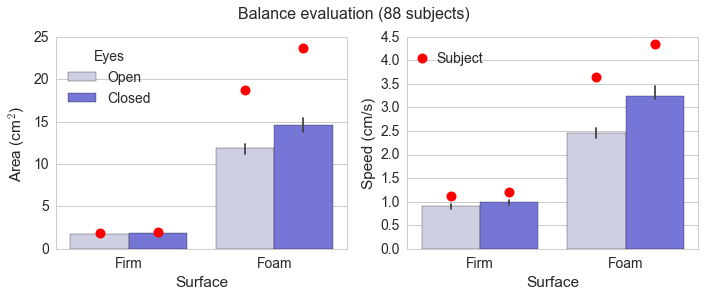

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
axa, xycia = bdb_plot_barplot(data=sel, sel=sel2, var='COParea', ylabel='Area (cm$^2$)', ax=ax[0],
                             legend=True, sel_lege=False)
axs, xycis = bdb_plot_barplot(data=sel, sel=sel2, var='COPvelo', ylabel='Speed (cm/s)', ax=ax[1])
plt.tight_layout()
subjects = pd.unique(sel2.Subject)
if sel is not None and len(pd.unique(sel.Subject)) == 1:
    title = 'Balance evaluation (subject: %s)' %sel['Subject'].iloc[0]
else:
    title = 'Balance evaluation (%d subjects)' %len(subjects)
plt.suptitle(title, fontsize=16, y=1.03)
plt.show()